In [1]:
import sys
sys.path.append('/home/scc/sergio.zanotto/.local/lib/python3.10/site-packages')
sys.path.append('/home/scc/sergio.zanotto/.local/bin')

In [2]:
import re
import xml.etree.ElementTree as ET
import stanza
import pandas as pd
import numpy as np
import nltk
from nltk import ngrams, Text, bigrams, BigramCollocationFinder 
from nltk.collocations import BigramAssocMeasures
import collections
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import itertools
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
from itertools import combinations
from collections import Counter
import os
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from scipy.stats import chi2_contingency
from fuzzywuzzy import fuzz
import csv
from collections import Counter

/home/scc/sergio.zanotto/.local/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
#Survey's answers
col_names = ["n_answer","text"]
dfs = pd.read_csv("Copy of Textual corpus - Representations of inequality.csv", names=col_names, encoding='latin-1')

In [4]:
dfs

,n_answer,text
0,1,Das es genug Arbeit in Deutschland gibt und ke...
1,2,Ungerecht
2,3,Geld
3,4,Ethnisch
4,5,Einkommen/ Vermögen
...,...,...
6314,6315,NaN
6315,6316,"Behandlung im Krankheitsfall, Schulbildungsmög..."
6316,6317,Finanziell
6317,6318,Weniger Lohn für Frauen bei gleicher Arbeit


In [5]:
df_t = dfs["text"] 

In [6]:
#Dictionaries: Inequality categories and not_to_categorize_words
categ = pd.read_csv("/home/scc/sergio.zanotto/tg/Copy of final_category_Nanna_CHECKEDBYSOPHIA&MB - Copy of final_category_Nanna_CHECKEDBYSOPHIA&MB1.csv", encoding='utf-8')
notto = pd.read_csv("/home/scc/sergio.zanotto/tg/notto.csv", encoding='latin-1')
list_to_manual_categ = pd.read_csv("/home/scc/sergio.zanotto/tg/Long_ans.csv", encoding='latin-1')

In [7]:
notto_list = notto["notto"].values.tolist()
text_to_manual_categ = list_to_manual_categ["text"].values.tolist()
cat_to_manual_cat = list_to_manual_categ["Category"].values.tolist()

In [8]:
n_list = dfs["n_answer"].values.tolist()
text_list = dfs["text"].values.tolist()

In [9]:
categ.head()

,Education,Wealth,rich,poverty,distribution_economic,Economy,Income,Taxation,Social_benefit,social_stratification,...,Politics/Institutions,Human_rights,inequality_before_the_law,football_world_championship_in_katar,environment,government_dissatisfaction,public_agencies,social_mobility,war,Global
0,Bildungsungleichheit,Vermögensungleichheit,reich,bettelarm,Arm&reich,finanzielll,einkommensdifferenz,brutto/netto,Bürgergeld,Mittelschicht,...,Politiker,menschenrecht,gesetzlich,Katar,Klima,lug,beamte,Chancen,krieg,Afrika
1,bildungsungerechtigkeit,Vermögensverteilung,reichtum,armut,reich/arm,finanziell,verdienstunterscheiden,erbschaftssteuer,hartz_iv,Status,...,politisch,meinungsfreiheit,rechtsprechung,WM,Klimawandel,trug,beamten,Chancengleichheit,Grieg,Die Welt
2,Bildung,vermögend,reich,arm,armut/reichtum,finanzielles,gehaltsfragen,steuersatz,hartziv,klassen,...,regierung,kindersrbeit,gesetz,WM in Katar,umweltungerechtigkeit,unwahrheit,beamter,chancengleichheit,NaN,Nord-Süd-Gefälle
3,ungebildet,vermögensumverteilung,reicht,verarmung,arm/reich,finanzieller,handwerkerlohn,steuerlich,hartz,Position,...,Staat,NaN,gericht,NaN,Tierschutz,unwahrheiten,verbeamtung,Chancenungleich,NaN,Porter EU
4,schulbildung,99%,reichen,armmut,arm-reich,finanziellen,lohnunterschied,abgeben,hartz-iv,schicht,...,Politik,menschenrechte,gesetzeslage,NaN,Speziesismus,NaN,Behörden,Chancenungleichheit,NaN,NaN


In [10]:
#Categories names
all_name = []
all_cat = []
all_name1 = []
for columnName, columnData in categ.items():
    columnName1 = columnName.lower()
    all_name.append(columnName)
    all_name1.append(columnName1)
    for y in columnData.values:
        y = str(y)
        y = y.lower()
        all_cat.append(y)

In [11]:
#Classification of answers given the founded keywords
def process_text_entry(x, categ, n_answer):
    x = str(x).lower()
    x = re.sub('[^\w\s]', ' ', x)
    words = x.split()
    
    result = {}
    misspelled_words = []
    
    for columnName, columnData in categ.items():
        matched_words = []
        for y in columnData.values:
            y = str(y).lower()
            y = re.sub('[^\w\s]', ' ', y)
            if y != "nan":
                y_list = y.split()
                y_length = len(y_list)
                for i in range(len(words) - y_length + 1):
                    if words[i:i+y_length] == y_list:
                        matched_words.extend(y_list)
                        del words[i:i+y_length]
                        break
        if matched_words:
            result[columnName] = {word: matched_words.count(word) for word in matched_words}
        else:
            for word in words:
                if word not in all_cat:
                    if word not in notto_list:
                        for y in columnData.values:
                            y = str(y).lower()
                            y = re.sub('[^\w\s]', ' ', y)
                            if y != "nan" and len(word) >= 6 and fuzz.ratio(word, y) >= 90:
                                misspelled_words.append((word + '?', columnName, n_answer))
                                result.setdefault(columnName, {})[word] = 1
    
    
    return result, misspelled_words

i = 0
dict_answer = {}
category_strings = []
csv_notcat= [["Id", "text"]]
for x, nn in zip(dfs["text"], dfs["n_answer"]):
    i += 1
    processed_result,misspelled_words = process_text_entry(x, categ, nn)
    dict_answer[nn] = processed_result

    mentioned_categories = list(processed_result.keys())
    
    x = str(x)
    y = x.lower()
        
    if "rich" in mentioned_categories and "poverty" in mentioned_categories: #handle "rich and poor" collocations
        mentioned_categories.remove("rich")
        mentioned_categories.remove("poverty")
        mentioned_categories.append("distribution_economic")
    if x == "nan":  # Handle empty answers (no answer)
        mentioned_categories.append("nan")
    if y == "social" or y == "soziale" or y == "soziales":
        mentioned_categories.append("Social") 
    for m, n in zip(text_to_manual_categ,cat_to_manual_cat): 
        n = n.lower()   
        if x == m:
            mentioned_categories.append(n)
    if x != "nan" and len(mentioned_categories) == 0:
        mentioned_categories.append("not_categorized")
        csv_notcat.append([nn, x])
        
    category_strings.append(' '.join(mentioned_categories))
    


In [12]:
from collections import Counter

# Count category frequencies from the category_strings list
category_frequency = Counter()
for category_string in category_strings:
    categories = category_string.split()
    category_frequency.update(categories)

# Filter categories with frequency greater than 10 and not equal to "Nan" or "Not Categorized"
filtered_category_frequency = {
    category.replace("_", " ").title(): freq
    for category, freq in category_frequency.items()
    if category not in ("nan", "not_categorized")
}

# Sort the filtered category frequencies from most frequent to least frequent
sorted_category_frequency = dict(sorted(filtered_category_frequency.items(), key=lambda x: x[1], reverse=True))

# Calculate the total occurrences
total_occurrences = sum(sorted_category_frequency.values())

# Create a table
table = [("Variables", "Frequency")]
for category, freq in sorted_category_frequency.items():
    table.append((category, freq))
table.append(("Total Occurrences", total_occurrences))

# Print the table
for row in table:
    print(f"{row[0]:<20} {row[1]:<10}")



Variables            Frequency 
Income               1306      
Distribution Economic 1010      
Gender               958       
Economy              654       
Working Conditions   430       
Social Benefit       323       
Education            283       
Social Stratification 254       
Racism               230       
Pensioners           178       
Wealth               154       
Taxation             141       
Poverty              138       
Politics/Institutions 138       
Rich                 114       
East/West Differences 113       
Healthcare Inequality 107       
Age                  95        
Lgbtq+               83        
Family Status        77        
Handicapped People   73        
Refugee              68        
Inequality Before The Law 67        
Social Mobility      66        
Housing Conditions   57        
Energy               49        
Human Rights         44        
Health               40        
Religion             37        
Differences Within Germany 34 

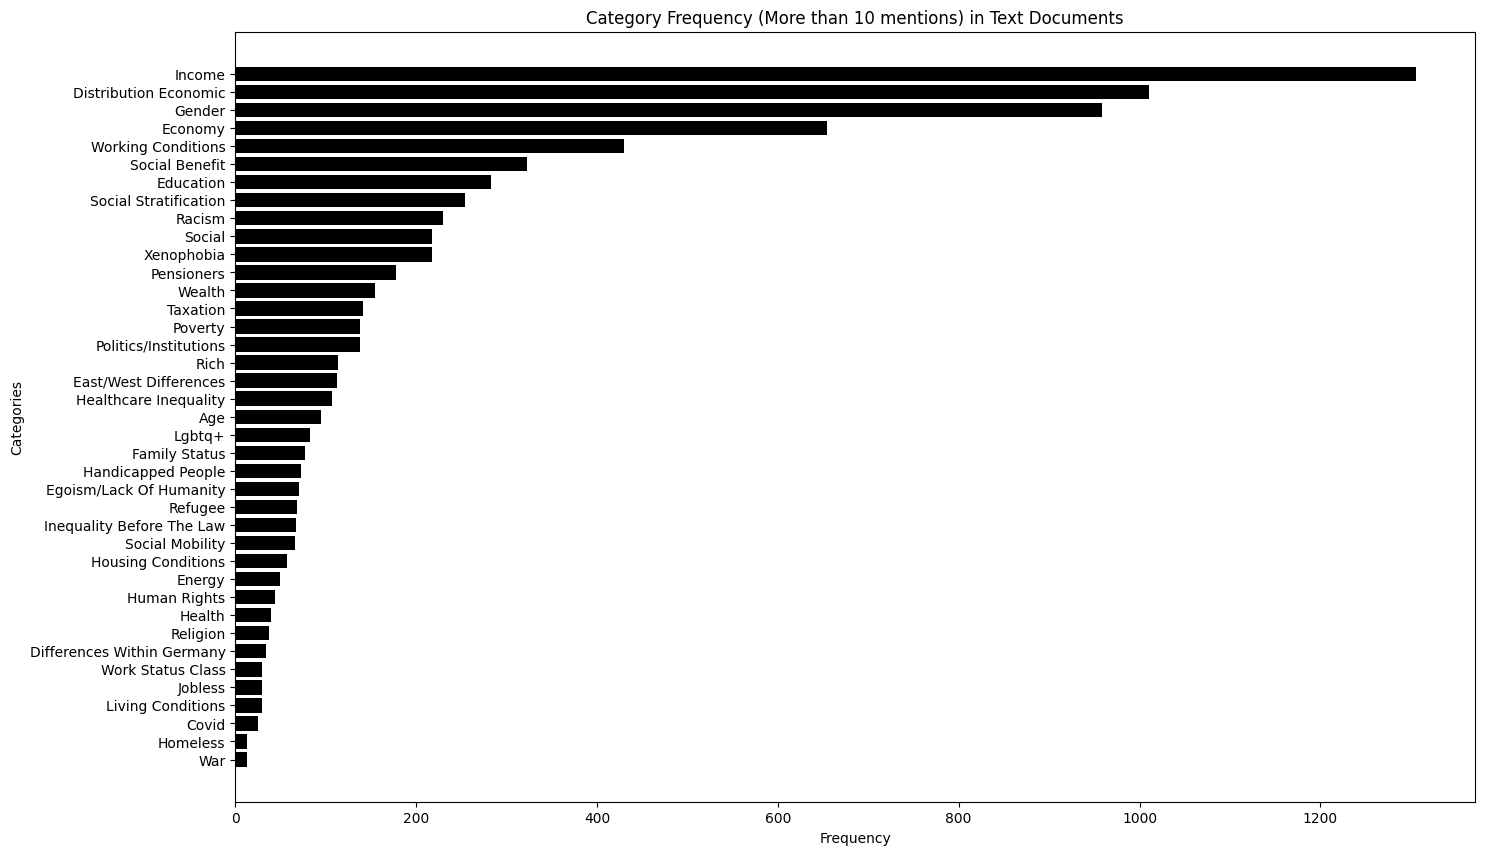

In [13]:
import matplotlib.pyplot as plt

# Initialize a Counter to keep track of category frequencies
category_frequency = Counter()

# Count category frequencies from the category_strings list
for category_string in category_strings:
    categories = category_string.split()
    category_frequency.update(categories)

filtered_category_frequency = {
    category.replace("_", " ").title(): freq
    for category, freq in category_frequency.items()
    if freq > 10 and category not in ("nan", "not_categorized")
}

# Sort the filtered category frequencies from most frequent to least frequent
sorted_category_frequency = dict(sorted(filtered_category_frequency.items(), key=lambda x: x[1], reverse=True))

# Extract categories and frequencies for plotting
categories = list(sorted_category_frequency.keys())
frequencies = list(sorted_category_frequency.values())

# Create a bar graph with a black and white color scheme
plt.figure(figsize=(16, 10))  # Adjust the figure size to make it as big as possible
plt.barh(categories, frequencies, color='black')  # Set the bar color to black
plt.xlabel('Frequency')
plt.ylabel('Categories')
plt.title('Category Frequency (More than 10 mentions) in Text Documents')

# Invert the y-axis for better readability
plt.gca().invert_yaxis()

# Save the graph as a PDF file
plt.savefig('Category_Frequency.pdf', format='pdf', bbox_inches='tight')

# Show the graph
plt.show()





In [14]:
from docx import Document
from docx.shared import Pt

# Create a new Word document
doc = Document()

# Create a table
table1 = doc.add_table(rows=1, cols=2)
table1.style = 'Table Grid'

# Set table column widths
table1.autofit = False
table1.columns[0].width = Pt(150)
table1.columns[1].width = Pt(100)

# Add headers to the table
table1.rows[0].cells[0].text = "Variables"
table1.rows[0].cells[1].text = "Frequency"

# Dictionary to map old labels to new labels
label_mapping = {
    "Social Benefit": "Social benefit",
    "Social Stratification": "Social stratification",
    "Work Status Class": "Work/status/class",
    "Working Conditions": "Working conditions",
    "Housing Conditions": "Housing conditions",
    "Living Conditions": "Living conditions",
    "Family Status": "Family",
    "Handicapped People": "Disability",
    "Body Weight": "Weight/obesity",
    "Health": "Health (general)",
    "Lgbtq+": "LGBTQ+",
    "Eastwest Differences": "East/West differences",
    "Differences Within Germany": "Differences Germany",
    "Covid": "COVID-19",
    "Healthcare Inequality": "Healthcare",
    "Egoism/lack Of Humanity": "Egoism/social",
    "Public Transport": "Public transportation",
    "Human Rights": "Human rights",
    "Law Ineq": "Inequality before the law",
    "Katar": "Football WC Katar",
    "Environment": "Environment",
    "Government Dissatisfaction": "Government/institutions (Dissatisfaction)",
    "Public Agencies": "Institutions",
    "Social Mobility": "Social mobility",
    "War": "War",
    "Nan": "Missing",
    "Not Categorized": "Not categorized",
    "Social": "Social issues (general)",
    "Distribution Economic": "Economy (distribution)",
    "Economy": "Economy (general)",
    "Rich": "Richness",
    "Poverty": "Poverty"
}


# Iterate through your data (assuming it's in a list of tuples like 'table')
for old_label, freq in table:
    # Apply label mapping
    new_label = label_mapping.get(old_label, old_label)
    # Capitalize the first letter
    new_label = new_label.capitalize()
    
    row = table1.add_row().cells
    row[0].text = new_label
    row[1].text = str(freq)

# Save the document to a file
doc.save("category_frequencies.docx")


In [15]:
# Specify the CSV file path
csv_file_path = "not_categorized.csv"

# Write the CSV table
with open(csv_file_path, "w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(csv_notcat)

# Initialize a Counter to keep track of keyword counts per person
person_keyword_counts = Counter()

# Initialize a Counter to keep track of how many people mentioned a specific number of keywords
people_keyword_counts = Counter()

# Initialize counters for "not answered" and "not categorized"
not_answered_count = 0
not_categorized_count = 0

for nn, processed_result in dict_answer.items():
    # Count the total number of keywords mentioned by a person
    total_keywords_mentioned = sum(sum(keyword_counts.values()) for keyword_counts in processed_result.values())
    
    # Update the Counter with the total keywords mentioned per person
    person_keyword_counts[nn] = total_keywords_mentioned
    
    # Update the Counter with how many people mentioned a specific number of keywords
    people_keyword_counts[total_keywords_mentioned] += 1

# Determine the number of people who didn't mention any keywords
num_people_with_zero_keywords = people_keyword_counts[0]

# Count the occurrences of "not_answered" and "not_categorized" in category_strings
for category_string in category_strings:
    if 'nan' in category_string:
        not_answered_count += 1
    if 'not_categorized' in category_string:
        not_categorized_count += 1

# Sort the keyword mentions from highest to lowest
sorted_keyword_mentions = sorted(people_keyword_counts.items(), key=lambda x: x[0], reverse=True)

# Specify the CSV file path
csv_file_path = "Keyword_Mentions_Per_Person.csv"

# Create a list of lists for the CSV table
csv_data = [["Number of Keywords Mentioned", "Number of People"]]

# Add rows for each keyword count
for num_keywords, num_people in sorted_keyword_mentions:
    csv_data.append([num_keywords, num_people])

# Add rows for "not_answered" and "not_categorized" categories
csv_data.extend([["Not Answered", not_answered_count],
                 ["Not Categorized", not_categorized_count]])
                 

# Write the CSV table
with open(csv_file_path, "w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(csv_data)



In [ ]:
#combining all survey data
dfd = pd.read_stata('/home/scc/sergio.zanotto/tg/2023-24.04_Inequality-Barometer-cleaned.dta')

In [ ]:
dfd.head()

In [ ]:
n_d = dfd["lfdn"].values.tolist()

In [ ]:
mm = []
for x in n_d:
    mm.append(str(int(x)))

In [ ]:
dfd["lfdn"] = mm

In [ ]:
dfs.head()

In [ ]:
dfd["cat"] = dfs["only_category"]

In [ ]:
all_name.append("nan")
all_name.append("not_categorized")
list_of_lists= {}
for y in all_name:
    listtt = []
    for x in dfd["cat"]:
        if y in x:
            listtt.append('1')
        else:
            listtt.append('0')
    list_of_lists[y] = listtt

In [ ]:
c = pd.DataFrame.from_dict(list_of_lists,orient='index').transpose()


In [ ]:
c["lfdn"] = dfd["lfdn"]

In [ ]:
official_data = pd.merge(dfd,c)

In [ ]:
for col in official_data.columns:
    if pd.api.types.is_categorical_dtype(official_data[col]):
        unique_categories = official_data[col].cat.categories
        if -99 not in unique_categories:
            official_data[col].cat.add_categories([-99], inplace=True)
        official_data[col].fillna(-99, inplace=True)
official_data.fillna(-99, inplace=True)

In [ ]:
official_data.to_csv("/home/scc/sergio.zanotto/tg/official_data.csv", index=False, header=True)
#end combining data

In [ ]:
#begin z_score calculation
official_data = pd.read_csv("/home/scc/sergio.zanotto/tg/official_data.csv", encoding='UTF-8', low_memory=False)

In [ ]:
nnn = official_data["cat"].values.tolist()
k = 0
for x in nnn:
    x = str(x)
    if "rich" in x:
        k += 1
print(k)

In [ ]:
gender_list = official_data["gender"].values.tolist()
gender_list = list(set(gender_list))
hhinc_cat_list = official_data["hhinc_cat"].values.tolist()
hhinc_cat_list = list(set(hhinc_cat_list))
party_withmiss_list = official_data["party_withmiss"].values.tolist()
party_withmiss_list = list(set(party_withmiss_list))
east_list = official_data["east"].values.tolist()
east_list = list(set(east_list))
age2_list = official_data["age2"].values.tolist()
age2_list = list(set(age2_list))
mig_list = official_data["mig"].values.tolist()
mig_list = list(set(mig_list))
## z-score check for soz17_1 (born in germany), 2(mum), 3(dad) if there is difference: mother vs father vs both migration background 

In [ ]:
exclude_values = ["Andere / k.A. / enthalten", "Divers"]  # Add other values you want to exclude
category_columns = ["mig", "gender", "hhinc_cat", "party_withmiss", "east", "age2"]
result_dataset = []

for category_column in category_columns:
    list_of_category = eval(f"{category_column}_list")
    category_data = []
    category_name = []
    num_documents = []
    for x in list_of_category:
        if x not in exclude_values:
            m = 0
            text = ""
            
            for y, z in zip(dfd[category_column], dfd["cat"]):
                if y == x:
                    m += 1
                    text = text + str(z) + " "
            category_name.append(x)
            category_data.append(text.lower())  # Store the category-specific text
            num_documents.append(m)  # Number of documents with this category
    
    # Create corpus text by combining all category texts
    corpus_text = " ".join(category_data)
    corpus_text = re.sub('\s+', ' ', corpus_text)
    corpus_text = re.sub('^\s+', '', corpus_text)
    corpus_text = re.sub('\s+$', '', corpus_text)
    corpus_text = corpus_text.split()
    
    # Calculate the vocabulary size (number of unique words)
    words_tt = pd.value_counts(np.array(corpus_text))
    V = len(words_tt.index)

    k = 0
    result_dict = {}
    for idx, category_specific_text in enumerate(category_data):
        k += 1
        list_of_relevant_words = []
        overused = []
        underused = []
        text = category_specific_text
        text = re.sub('\s+', ' ', text)
        text = re.sub('^\s+', '', text)
        text = re.sub('\s+$', '', text)
        text = text.split()
        words_pp = pd.value_counts(np.array(text))
        i = 0
        for w in words_pp.index:
            CW = len(text)
            C = len(corpus_text) 
            C_ = C - CW
            a = words_pp.values[i]
            i+= 1
            b = corpus_text.count(w)
            b = b - a
            c = CW - a
            d = C_ - b
            Pw = (a + b) / C
            PCW = (a + c) / C
            Pw_in_CW_in_C = a/C 
            #//Mutual Information
            Mutual_Information = math.log2((Pw_in_CW_in_C/(Pw * PCW)))
            #//Chi-square
            contingency_frame = pd.DataFrame({'Word' : [a,b], 'Non-Word' : [c,d]})
            h, p, dof, expected = chi2_contingency(contingency_frame)
            PWsmoothed = (a + b + 0.5) / (C + (0.5 * V))
            squareb = math.sqrt((CW*PWsmoothed*(1-PWsmoothed)))
            up = a-(CW*PWsmoothed)
            zscorew = up/squareb
            
            if Mutual_Information > 1 and h > 6.63 and p < 0.01:
                list_of_relevant_words.append(w)
            if zscorew > 2:
                overused.append((w, zscorew))
            if zscorew < -2:
                underused.append((w, zscorew))

        result_dict[category_name[idx]] = {
            "overused_words": overused,
            "underused_words": underused,
            "relevant_words": list_of_relevant_words,
            "num_documents": num_documents
        }
        
        result_dataset.append([category_column, category_name[idx], num_documents[idx], overused, underused])

result_df = pd.DataFrame(result_dataset, columns=["Category", "Specific_Category", "Num_Documents", "Overused_Words", "Underused_Words"])

# Now, relevant words are in the result_dict dictionary,
# and the summarized information in the result_dataset list of lists

In [ ]:
result_df.to_csv("zsquare_control.csv", index=False, header=True)  